# Notebook for generating all an only the figures related to the paper!

## General setup

### Figure path

In [1]:
PATH="/home/camontan/tmp/"
DPI=600

In [1]:
PATH="../PAPER_DIFFUSION/figs/"
DPI=600

In [2]:
DATA_PATH = "/home/camontan/moving_barrier_data"

In [3]:
%matplotlib inline

### Libraries

In [4]:
import pickle
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
import scipy
import scipy.integrate
import scipy.interpolate
from tqdm.notebook import tqdm
import crank_nicolson_numba.generic as cn
import itertools
import os
# For parallelization
from joblib import Parallel, delayed

import lmfit
import nekhoroshev_tools as nt

In [5]:
from uncertainties import ufloat

In [6]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
matplotlib.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

### Test for the path

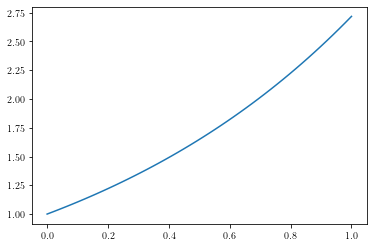

In [7]:
plt.figure()
plt.plot(np.linspace(0, 1), np.exp(np.linspace(0, 1)))

plt.savefig(os.path.join(PATH+"test.pdf"), dpi=DPI)

In [39]:
figsize = (7, 4)
figsize_compressed = (7, 3)
figsize_compressed_half = (7, 3.5)
figsize_large = (7, 5)


## Model presentation

### Just the diffusion coefficient

In [9]:
I_star = 1.0
k = 0.33
exponent = 1/(k*2)
k_low = 0.20
exponent_low = 1/(k_low*2)
k_high = 0.50
exponent_high = 1/(k_high*2)

In [10]:
I0 = np.ones(1000)
I0[-100:] = 0
engine1 = cn.cn_generic(0, 1.5, I0, 0.001, lambda x : nt.D(x, 1, 1/k, 1.0, True), False)
engine2 = cn.cn_generic(0, 1.5, I0, 0.001, lambda x : nt.D(x, 1, 1/k_low, 1.0, True), False)
engine3 = cn.cn_generic(0, 1.5, I0, 0.001, lambda x : nt.D(x, 1, 1/k_high, 1.0, True), False)

/home/camontan/Insync/carlo.montanari3@studio.unibo.it/OneDrive_Biz/projects/new_games_with_diffusion/nekhoroshev_tools.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  return c * np.exp(-2*np.power(I_star/I, exponent)) * (0.5 if halved else 1.0)
/home/camontan/Insync/carlo.montanari3@studio.unibo.it/OneDrive_Biz/projects/new_games_with_diffusion/nekhoroshev_tools.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  return c * np.exp(-2*np.power(I_star/I, exponent)) * (0.5 if halved else 1.0)


In [11]:
engine1.reset()
engine2.reset()
engine3.reset()
data0 = engine1.get_data_with_x()
engine1.iterate(10000)
engine2.iterate(10000)
engine3.iterate(10000)
data1 = engine1.get_data_with_x()
data2 = engine2.get_data_with_x()
data3 = engine3.get_data_with_x()

In [12]:
time = 0.001 * 10000

In [13]:
I = np.linspace(0.01, 1.5, 1000)

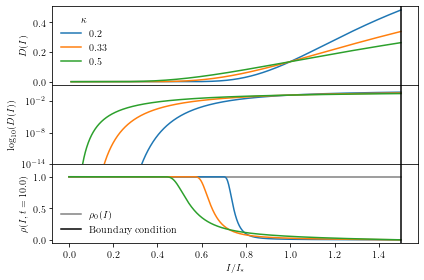

In [27]:
fig = plt.figure()#(figsize=(5, 3))
gs = gridspec.GridSpec(3, 1, height_ratios=[1, 1, 1])

ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1], sharex=ax0)
ax2 = plt.subplot(gs[2], sharex=ax0)

ax0.plot(I, nt.D(I, I_star, exponent_low), label=str(k_low))
ax1.plot(I, nt.D(I, I_star, exponent_low))
ax0.plot(I, nt.D(I, I_star, exponent), label=str(k))
ax1.plot(I, nt.D(I, I_star, exponent))
ax0.plot(I, nt.D(I, I_star, exponent_high), label=str(k_high))
ax1.plot(I, nt.D(I, I_star, exponent_high))

ax2.plot(data1[0], np.ones_like(data1[0]), c="grey", label="$\\rho_0(I)$")
ax2.plot(data1[0], data2[1])
ax2.plot(data1[0], data1[1])
ax2.plot(data1[0], data3[1])

#ax0.axvline(I_star, c="red")
#ax1.axvline(I_star, c="red")
#ax2.axvline(I_star, c="red", label="$I/I_*=1$")

ax0.axvline(1.5, c="black")
ax1.axvline(1.5, c="black")
ax2.axvline(1.5, c="black", label="Boundary condition")

ax0.legend(title="$\\kappa$", frameon=False)
ax2.legend(loc="lower left", frameon=False)

ax1.set_yscale("log")
ax1.set_ylim(bottom=1e-14, top=10)

plt.setp(ax0.get_xticklabels(), visible=False)

ax2.set_xlabel("$I/I_\\ast$")
ax0.set_ylabel("$D(I)$")
ax1.set_ylabel("$\\log_{10}(D(I))$")
ax2.set_ylabel("$\\rho(I, t={})$".format(time))
ax2.set_ylim(top=1.2)

plt.tight_layout()
plt.subplots_adjust(hspace=.0)
plt.setp(ax0.get_xticklabels(), visible=False)
yticks = ax1.yaxis.get_major_ticks()
#yticks[-3].label1.set_visible(False)

plt.savefig(os.path.join(PATH+"diffusion_coefficient.pdf"), dpi=DPI, pad_inches=0.0)


## Semi-stationary

In [17]:
idx = np.argmin(data1[1]> 0.9) - 1

def stat_f(I, alpha):
    return [alpha * scipy.integrate.quad(
        lambda x: 1/nt.D(x, 1, 1/k, 1.0),
        i, 1.5
    )[0] for i in I]

def stat_f_log(I, alpha):
    result = [alpha + np.log10(scipy.integrate.quad(
        lambda x: 1/nt.D(x, 1, 1/k, 1.0),
        i, 1.5
    )[0]) for i in I]
    return result

popt, pcov = scipy.optimize.curve_fit(
    stat_f,
    data1[0][idx:-1],
    data1[1][idx:-1],
    p0=1
)

popt_log, pcov_log = scipy.optimize.curve_fit(
    stat_f_log,
    data1[0][idx:-1],
    np.log10(data1[1][idx:-1]),
    p0=1
)

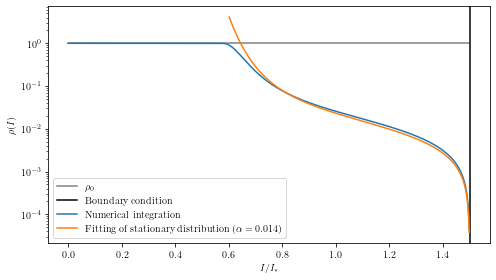

In [18]:
plt.figure(figsize=figsize)
plt.plot(data1[0][:], np.ones_like(data1[1][:]), c="grey", label="$\\rho_0$")
plt.axvline(1.5, c="black", label="Boundary condition")

plt.plot(data1[0][:], data1[1][:], label="Numerical integration")
plt.plot(data1[0][idx:], np.array(stat_f(data1[0][idx:], 10**popt_log[0])), label="Fitting of stationary distribution $(\\alpha = {:.2})$".format(10**popt_log[0]))

plt.xlabel("$I/I_\\ast$")
plt.ylabel("$\\rho(I)$")

plt.legend()

plt.yscale("log")
plt.tight_layout()

#plt.savefig(os.path.join(PATH+"stationary_distribution.pdf"), dpi=DPI)

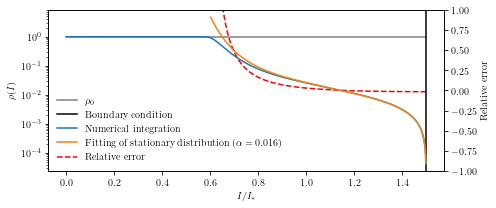

In [28]:
fig, ax1 = plt.subplots(figsize=figsize_compressed)
ax2 = ax1.twinx()

ax1.plot(data1[0][:], np.ones_like(data1[1][:]), c="grey", label="$\\rho_0$")
ax1.axvline(1.5, c="black", label="Boundary condition")

ax2.plot(data1[0][idx:], 
         (np.array(stat_f(data1[0][idx:], 10**popt_log[0] + 0.002)) - data1[1][idx:]) / data1[1][idx:],
         "--", c="red"
        )

ax1.plot(data1[0][:], data1[1][:], label="Numerical integration")


fit_data = data1[0][idx:], np.array(stat_f(data1[0][idx:], 10**popt_log[0]))

ax1.plot(data1[0][idx:], np.array(stat_f(data1[0][idx:], (10**popt_log[0] + 0.002))), label="Fitting of stationary distribution $(\\alpha = {:.2})$".format(10**popt_log[0] +0.002))

ax1.plot([],[],"--", c="red", label="Relative error")

ax1.set_xlabel("$I/I_\\ast$")
ax1.set_ylabel("$\\rho(I)$")

ax1.legend(frameon=False)

ax1.set_yscale("log")
ax2.set_ylim(-1.0, 1.0)
ax1.set_zorder(ax2.get_zorder()+10)
ax1.patch.set_visible(False)
ax2.set_ylabel("Relative error")
plt.tight_layout()

plt.savefig(os.path.join(PATH+"stationary_distribution.pdf"), dpi=DPI, pad_inches=0.0)

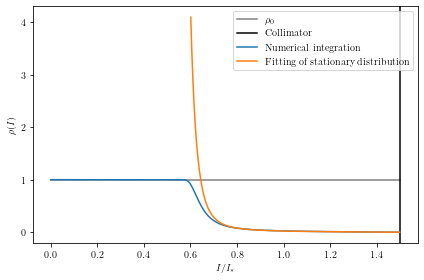

In [29]:
plt.plot(data1[0][:], np.ones_like(data1[1][:]), c="grey", label="$\\rho_0$")
plt.axvline(1.5, c="black", label="Collimator")

plt.plot(data1[0][:], data1[1][:], label="Numerical integration")
plt.plot(data1[0][idx:], np.array(stat_f(data1[0][idx:], 10**popt_log[0])), label="Fitting of stationary distribution")

plt.xlabel("$I/I_\\ast$")
plt.ylabel("$\\rho(I)$")

plt.legend()

#plt.yscale("log")
plt.tight_layout()

#plt.savefig(os.path.join(PATH+"stationary_distribution.pdf"), dpi=DPI)

## Difference in distributions for stationary

In [30]:
I_star = 1.0
k = 0.33
exponent = 1/(k*2)

gap = 0.05

In [31]:
I_min = 0.4
I_max = 1.0
c = nt.standard_c(0.0, I_max, I_star, exponent)
sampling = 10000


I = np.linspace(I_min, I_max+gap, sampling)

I0 = nt.stationary_dist(I, I_max, I_star, exponent, c)
I0[I0 < 0] = 0.0

I0_bis = nt.stationary_dist(I, I_max + gap, I_star, exponent, c)

I0_ter = nt.stationary_dist(I, I_max - gap, I_star, exponent, c)
I0_ter[I0_ter < 0] = 0.0

I0 /= I0[0]
I0_bis /= I0_bis[0]
I0_ter /= I0_ter[0]

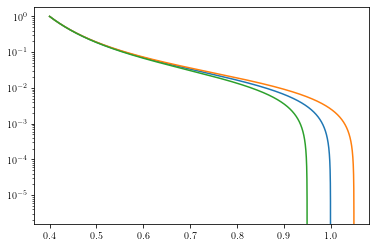

In [32]:
plt.plot(I, I0)
plt.plot(I, I0_bis)
plt.plot(I, I0_ter)
plt.yscale("log")

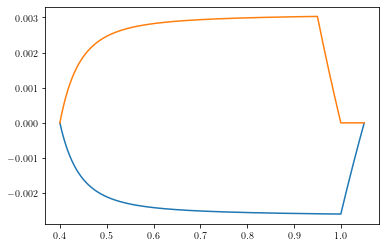

In [33]:
plt.plot(I, I0 - I0_bis)
plt.plot(I, I0 - I0_ter)

/tmp/ipykernel_44820/1846748494.py:35: RuntimeWarning: divide by zero encountered in true_divide
  ax1_bis.plot(I[1:], (np.concatenate((block1, block2))[1:] - (- I0_bis[:idx] + I0[:idx]))/(- I0_bis[:idx] + I0[:idx]), c="C1", linestyle="dashdot")


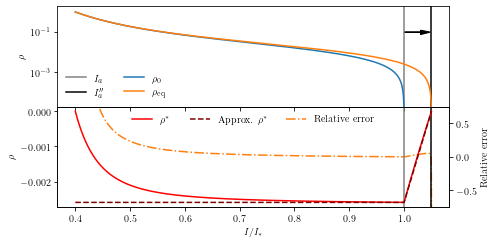

In [50]:
fig = plt.figure(figsize=figsize_compressed_half)#(figsize=(5, 3))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1])

ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1], sharex=ax0)

ax1_bis = ax1.twinx()

idx = -1

ax0.axvline(I_max, color="grey", label="$I_a$")
ax0.axvline(I_max + gap, color="black", label="$I''_a$")

ax0.plot(I[:idx], I0[:idx], label="$\\rho_0$")
ax0.plot(I[:idx], I0_bis[:idx], label="$\\rho_\\text{eq}$")
ax0.set_yscale("log")

ax0.legend(ncol=2, frameon=False)
ax0.set_ylim(bottom=0.2e-4)

ax0.arrow(I_max, 1e-1, gap - 0.02, 0.0, head_width=0.05, head_length=0.018, fc='k', ec='k')

ax1.axvline(I_max, color="grey")
ax1.axvline(I_max + gap, color="black")

idx2 = np.argmax(I>I_max)

ax1.plot(I[:idx], - I0_bis[:idx] + I0[:idx], color="red", label="$\\rho^*$")

block1 = np.ones_like(I[:idx2]) * (- I0_bis[:idx] + I0[:idx])[idx2]
block2 = np.linspace((- I0_bis[:idx] + I0[:idx])[idx2], 0.0, len(I) - idx2)

ax1.plot(I, np.concatenate((block1, block2)), "--", color="maroon", label="Approx. $\\rho^*$")

ax1_bis.plot(I[1:], (np.concatenate((block1, block2))[1:] - (- I0_bis[:idx] + I0[:idx]))/(- I0_bis[:idx] + I0[:idx]), c="C1", linestyle="dashdot")
ax1_bis.set_ylim(-0.75, 0.75)

ax1.plot([],[],c="C1", linestyle="dashdot", label="Relative error")

ax1.set_zorder(ax1_bis.get_zorder()+10)
ax1.patch.set_visible(False)

ax1.legend(ncol=3, frameon=False)

ax1.set_xlabel("$I / I_\\ast$")
ax0.set_ylabel("$\\rho$")
ax1.set_ylabel("$\\rho$")
ax1_bis.set_ylabel("Relative error")

plt.tight_layout()

plt.setp(ax0.get_xticklabels(), visible=False)
plt.subplots_adjust(hspace=.0)

plt.savefig(os.path.join(PATH+"difference_outwards.pdf"), dpi=DPI, pad_inches=0.0)


### Currents...

In [51]:
c = nt.standard_c(0.0, I_max+gap, I_star, exponent)
engine = cn.cn_generic(I_min, I_max+gap, I0[:], 0.000001, lambda x : nt.D(x, I_star, exponent, c, True), False)
engine.lock_left()

In [52]:
data = engine.current(10000, 2, False)

100%|██████████| 10000/10000 [00:03<00:00, 3047.22it/s]


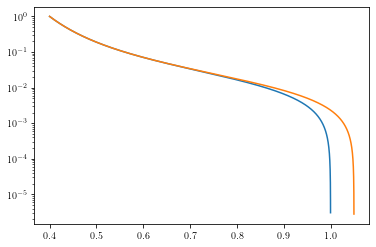

In [53]:
plt.plot(I[:idx2], I0[:idx2])
coso = engine.get_data_with_x()
plt.plot(coso[0], coso[1])
plt.yscale("log")

In [54]:
shame_idx = np.argmin(data[1])

times_array = np.linspace(data[0][shame_idx], data[0][-1], 100)
rho = scipy.interpolate.interp1d(I, - I0_bis[:] + I0[:], kind='cubic')
current = nt.current_generic(times_array, rho, I[:idx][-1], I_min, I_star, exponent, c)

rho = scipy.interpolate.interp1d(I, np.concatenate((block1, block2)), kind='cubic')
current_approx = nt.current_generic(times_array, rho, I[:idx][-1], I_min, I_star, exponent, c)

In [55]:
f_temp = scipy.interpolate.interp1d(data[0], data[1], kind="cubic")

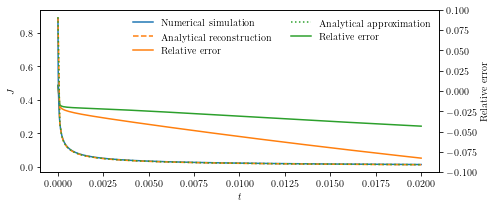

In [70]:
fig, ax1 = plt.subplots(figsize=figsize_compressed)
ax2 = ax1.twinx()

ax1.set_zorder(ax2.get_zorder()+10)
ax1.patch.set_visible(False)

ax1.plot(data[0][shame_idx:], data[1][shame_idx:], label="Numerical simulation")
ax1.plot(times_array, current, "--", label="Analytical reconstruction")
ax1.plot([], [], c="C1", label="Relative error")
ax1.plot(times_array, current_approx, linestyle="dotted", label="Analytical approximation")
ax1.plot([], [], c="C2", label="Relative error")
#plt.yscale("log")

ax2.plot(times_array, (current - f_temp(times_array))/f_temp(times_array), c="C1")
ax2.plot(times_array, (current_approx - f_temp(times_array))/f_temp(times_array), c="C2")

ax1.plot()

ax1.set_xlabel("$t$")
ax1.set_ylabel("$J$")
ax1.legend(ncol=2, frameon=False)

ax2.set_ylim(-0.1, 0.1)
ax2.set_ylabel("Relative error")

plt.tight_layout()

plt.savefig(os.path.join(PATH+"current_outwards.pdf"), dpi=DPI, pad_inches=0.0)


### And now the other one

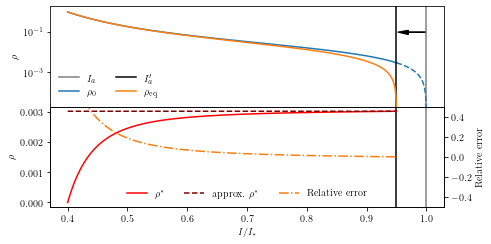

In [71]:
fig = plt.figure(figsize=figsize_compressed_half)#(figsize=(5, 3))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1])

ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1], sharex=ax0)
ax1_bis = ax1.twinx()

idx = np.argmax(I>I_max)
idx2 = np.argmax(I>I_max-gap)

ax0.axvline(I_max, color="grey", label="$I_a$")

ax0.plot(I[:idx2], I0[:idx2], label="$\\rho_0$")
ax0.plot(I[idx2:idx], I0[idx2:idx], "--", c="C0")
ax0.axvline(I_max - gap, color="black", label="$I'_a$")
ax0.plot(I[:idx], I0_ter[:idx], label="$\\rho_\\text{eq}$")
ax0.set_yscale("log")

ax0.legend(ncol=2, frameon=False)
ax0.set_ylim(bottom=0.2e-4)

ax0.arrow(I_max, 1e-1, - gap + 0.02, 0.0, head_width=0.05,
          head_length=0.018, fc='k', ec='k')


ax1.axvline(I_max, color="grey")
ax1.axvline(I_max - gap, color="black")

idx = np.argmax(I>I_max-gap)

ax1.plot(I[:idx], - I0_ter[:idx] + I0[:idx], color="red", label="$\\rho^*$")
ax1.plot(I[:idx], np.ones_like(I[:idx]) * (- I0_ter[:idx] + I0[:idx])[-1], "--", color="maroon", label="approx. $\\rho^*$")
ax1.plot([],[], linestyle="dashdot", c="C1", label="Relative error")

ax1_bis.plot(I[:idx],
             (np.ones_like(I[:idx]) * (- I0_ter[:idx] + I0[:idx])[-1] + I0_ter[:idx] - I0[:idx])/(np.ones_like(I[:idx]) * (- I0_ter[:idx] + I0[:idx])[-1]),
             c="C1", linestyle="dashdot")
ax1_bis.set_ylim(-0.5, 0.5)

ax1.legend(ncol=3, frameon=False)

ax1.set_xlabel("$I / I_\\ast$")
ax0.set_ylabel("$\\rho$")
ax1.set_ylabel("$\\rho$")
ax1_bis.set_ylabel("Relative error")

plt.tight_layout()

plt.setp(ax0.get_xticklabels(), visible=False)
plt.subplots_adjust(hspace=.0)

plt.savefig(os.path.join(PATH+"difference_backwards.pdf"), dpi=DPI, pad_inches=0.0)


### Currents...

In [61]:
c = nt.standard_c(0.0, I_max-gap, I_star, exponent)
engine = cn.cn_generic(I_min, I_max-gap, I0[:idx2], 0.000001, lambda x : nt.D(x, I_star, exponent, c, True), False)
engine.lock_left()

In [62]:
data = engine.current(10000, 2, False)

100%|██████████| 10000/10000 [00:02<00:00, 3571.96it/s]


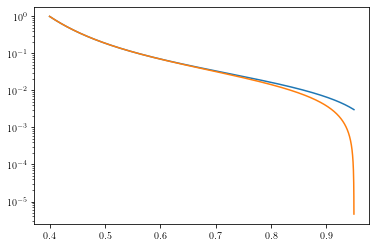

In [63]:
plt.plot(I[:idx2], I0[:idx2])
coso = engine.get_data_with_x()
plt.plot(coso[0], coso[1])
plt.yscale("log")

In [64]:
shame_idx = 5
times_array = np.linspace(data[0][shame_idx], data[0][-1], 200)
rho = scipy.interpolate.interp1d(I[:idx2], I0[:idx2] - I0_ter[:idx2], kind='cubic')
current = nt.current_generic(times_array, rho, I[:idx2][-1], I_min, I_star, exponent, c)

current_approx = nt.current_generic(times_array, lambda x : rho(I[:idx2][-1]), I[:idx2][-1], I_min, I_star, exponent, c)

In [65]:
alpha = 1 / scipy.integrate.quad(lambda x : 1/nt.D(x, I_star, exponent, c), 0.4, 1.0)[0]

In [66]:
rho(I[:idx2][-1])

array(0.00302822)

In [67]:
alpha * scipy.integrate.quad(lambda x : 1/nt.D(x, I_star, exponent, c), I[:idx2][-1], 1.0)[0]

0.0030311846544093775

In [68]:
f_temp = scipy.interpolate.interp1d(data[0], data[1], kind="cubic")

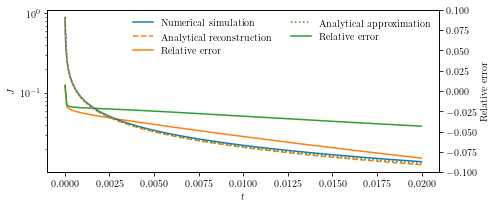

In [72]:
fig, ax1 = plt.subplots(figsize=figsize_compressed)
ax2 = ax1.twinx()

ax1.set_zorder(ax2.get_zorder()+10)
ax1.patch.set_visible(False)

ax1.plot(data[0][shame_idx:], data[1][shame_idx:], label="Numerical simulation")
ax1.plot(times_array, current, "--", label="Analytical reconstruction")
ax1.plot([], [], c="C1", label="Relative error")
ax1.plot(times_array, current_approx, linestyle="dotted", label="Analytical approximation")
ax1.plot([], [], c="C2", label="Relative error")
#plt.yscale("log")

ax2.plot(times_array, (current - f_temp(times_array))/f_temp(times_array), c="C1")
ax2.plot(times_array, (current_approx - f_temp(times_array))/f_temp(times_array), c="C2")

ax1.set_xlabel("$t$")
ax1.set_ylabel("$J$")
ax2.set_ylim(-0.1, 0.1)
ax2.set_ylabel("Relative error")
ax1.set_yscale("log")

ax1.legend(ncol=2, frameon=False)
plt.tight_layout()

plt.savefig(os.path.join(PATH+"current_backwards.pdf"), dpi=DPI, pad_inches=0.0)

## Comparison between the recovery currents

In [73]:
I_star = 1.0
k = 0.33
exponent = 1/(k*2)

gap = 0.05

I_min = 0.0
I_max = 1.0
c = nt.standard_c(0.0, I_max, I_star, exponent)
sampling = 10000

I = np.linspace(0.0, I_max, sampling)
I0 = np.exp(-I)

cn_time_steps = 10000
dt = nt.afpt(I_max, I_max + gap, I_star, exponent, c) / cn_time_steps

In [74]:
dt

1.8984591713252536e-06

In [75]:
engine = cn.cn_generic(
    I_min,
    I_max,
    I0,
    dt,
    lambda x: nt.D(x, I_star, exponent, c, True),
    normalize=True
)

engine_out = cn.cn_generic(
    I_min,
    I_max,
    I0,
    dt,
    lambda x: nt.D(x, I_star, exponent, c, True),
    normalize=True
)


engine_in = cn.cn_generic(
    I_min,
    I_max,
    I0,
    dt,
    lambda x: nt.D(x, I_star, exponent, c, True),
    normalize=True
)

/home/camontan/Insync/carlo.montanari3@studio.unibo.it/OneDrive_Biz/projects/new_games_with_diffusion/nekhoroshev_tools.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  return c * np.exp(-2*np.power(I_star/I, exponent)) * (0.5 if halved else 1.0)


In [76]:
data_0 = engine.current(4000, 2, False)

engine.reset()
data_0_bis = engine.current(1000, 2, False)
data_0_ter = engine.current(3000, 2, False)

data_1 = engine_out.current(1000, 2, False)
engine_out.move_barrier_forward(gap)
data_2 = engine_out.current(3000, 2, False)


data_3 = engine_in.current(1000, 2, False)
engine_in.move_barrier_backward(gap)
data_4 = engine_in.current(3000, 2, False)

100%|██████████| 1000/1000 [00:00<00:00, 3166.68it/s]
/home/camontan/Insync/carlo.montanari3@studio.unibo.it/OneDrive_Biz/projects/new_games_with_diffusion/nekhoroshev_tools.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  return c * np.exp(-2*np.power(I_star/I, exponent)) * (0.5 if halved else 1.0)
100%|██████████| 3000/3000 [00:00<00:00, 3353.27it/s]


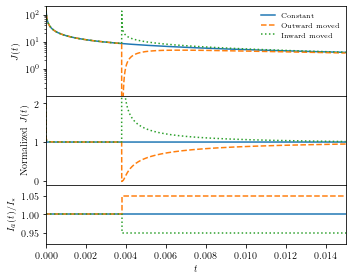

In [77]:
fig = plt.figure(figsize=(5, 4))
gs = gridspec.GridSpec(3, 1, height_ratios=[3, 3, 2])

ax0 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1], sharex=ax0)
ax1 = plt.subplot(gs[2], sharex=ax0)

ax0.plot(
    data_0[0],
    data_0[1],
    label="Constant"
)
ax0.plot(
    np.concatenate((data_1[0], data_2[0])),
    np.concatenate((data_1[1], data_2[1])),
    "--",
    label="Outward moved"
)
ax0.plot(
    np.concatenate((data_1[0], data_4[0])),
    np.concatenate((data_1[1], data_4[1])),
    linestyle="dotted",
    label="Inward moved"
)

ax2.plot(
    data_0[0],
    data_0[1]/data_0[1],
    label="Immovable boundary"
)
ax2.plot(
    np.concatenate((data_1[0], data_2[0])),
    np.concatenate((data_1[1]/data_0_bis[1], data_2[1]/data_0_ter[1])),
    "--",
    label="Outward moving boundary"
)
ax2.plot(
    np.concatenate((data_1[0], data_4[0])),
    np.concatenate((data_1[1]/data_0_bis[1], data_4[1]/data_0_ter[1])),
    linestyle="dotted",
    label="Inward moving boundary"
)

ax0.legend(fontsize="x-small", frameon=False)

ax0.set_yscale("log")
ax0.set_ylim(1.01e-1, 2e2)
ax0.set_xlim(0, 0.015)

ax1.axhline(1.0, c="C0")
ax1.plot([0.0, data_1[0][-1], data_1[0][-1], 0.015], [1.0, 1.0, 1.05, 1.05], "--", c="C1")
ax1.plot([0.0, data_1[0][-1], data_1[0][-1], 0.015], [1.0, 1.0, 0.95, 0.95], linestyle="dotted", c="C2")
ax1.set_ylim(0.92, 1.08)
ax2.set_ylim(-0.1, 2.2)


ax0.set_ylabel("$J(t)$")
ax2.set_ylabel("Normalized $J(t)$")
ax1.set_xlabel("$t$")
ax1.set_ylabel("$I_a(t) / I_\\ast$")

plt.tight_layout()

plt.setp(ax0.get_xticklabels(), visible=False)
plt.setp(ax2.get_xticklabels(), visible=False)
plt.subplots_adjust(hspace=.0)

plt.savefig(os.path.join(PATH+"global_vs_moving_current.pdf"), dpi=DPI, pad_inches=0.0)

## The Protocol

In [78]:
I_star = 1.0
k = 0.33
exponent = 1/(k*2)

gap = 0.02

I_min = 0.0
I_max = 1.0
c = nt.standard_c(0.0, I_max, I_star, exponent)
sampling = 10000

I = np.linspace(0.0, I_max, sampling)
I0 = np.exp(-I)

cn_time_steps = 10000
dt = nt.afpt(I_max, I_max + gap, I_star, exponent, c) / cn_time_steps

In [79]:
I_max = 1.0

engine = cn.cn_generic(
    I_min,
    I_max,
    I0,
    dt,
    lambda x: nt.D(x, I_star, exponent, c, True),
    normalize=True
)

engine_immovable = cn.cn_generic(
    I_min,
    I_max,
    I0,
    dt,
    lambda x: nt.D(x, I_star, exponent, c, True),
    normalize=True
)

/home/camontan/Insync/carlo.montanari3@studio.unibo.it/OneDrive_Biz/projects/new_games_with_diffusion/nekhoroshev_tools.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  return c * np.exp(-2*np.power(I_star/I, exponent)) * (0.5 if halved else 1.0)


In [80]:
steps = 7000
big_steps = 7000

times = []
collimators = []

data = []
data_immovable = []

times.append(0.0)
collimators.append(I_max)

data.append(engine.analytical_current(steps, 2, False))
data_immovable.append(engine_immovable.analytical_current(steps, 2, False))

times.append(data[-1][0][-1])
collimators.append(I_max)

new_I_max = I_max
for i in tqdm(range(3)):
    engine.move_barrier_forward(gap)
    new_I_max += gap

    times.append(data[-1][0][-1])
    collimators.append(new_I_max)
    
    data.append(engine.analytical_current(big_steps, 2, True))
    
    times.append(data[-1][0][-1])
    collimators.append(new_I_max)
    
    engine.move_barrier_backward(gap)
    new_I_max -= gap
    
    times.append(data[-1][0][-1])
    collimators.append(new_I_max)
    
    data.append(engine.analytical_current(big_steps, 2, True))
    
    times.append(data[-1][0][-1])
    collimators.append(new_I_max)
    
    engine.move_barrier_forward(gap)
    new_I_max += gap

    times.append(data[-1][0][-1])
    collimators.append(new_I_max)

    data.append(engine.analytical_current(big_steps, 2, True))

    times.append(data[-1][0][-1])
    collimators.append(new_I_max)

    data_immovable.append(
        engine_immovable.analytical_current(big_steps, 2, True))
    data_immovable.append(
        engine_immovable.analytical_current(big_steps, 2, True))
    data_immovable.append(
        engine_immovable.analytical_current(big_steps, 2, True))

# engine.move_barrier_forward(gap)

# times.append(data[-1][0][-1])
# collimators.append(I_max + gap)

# data.append(engine.analytical_current(big_steps, 2, False))
# data_immovable.append(engine_immovable.analytical_current(big_steps, 2, False))

# times.append(data[-1][0][-1])
# collimators.append(I_max + gap)

# engine.move_barrier_forward(gap)

# times.append(data[-1][0][-1])
# collimators.append(I_max + gap * 2)

# data.append(engine.analytical_current(big_steps, 2, False))
# data_immovable.append(engine_immovable.analytical_current(big_steps, 2, False))

# times.append(data[-1][0][-1])
# collimators.append(I_max + gap * 2)


100%|██████████| 7000/7000 [00:02<00:00, 3492.31it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

In [81]:
times

[0.0,
 0.010931155231910312,
 0.010931155231910312,
 0.021863872280541857,
 0.021863872280541857,
 0.032796589329173405,
 0.032796589329173405,
 0.04372930637780495,
 0.04372930637780495,
 0.054662023426436494,
 0.054662023426436494,
 0.06559474047506804,
 0.06559474047506804,
 0.07652745752369958,
 0.07652745752369958,
 0.08746017457233113,
 0.08746017457233113,
 0.09839289162096267,
 0.09839289162096267,
 0.10932560866959422]

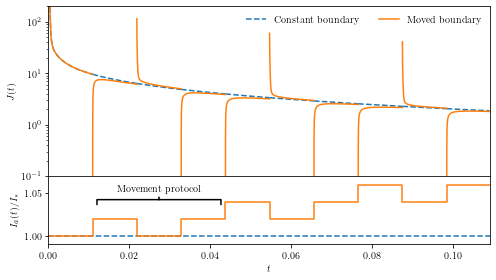

In [94]:
fig = plt.figure(figsize=figsize)
#fig = plt.figure(figsize=(5, 4))
gs = gridspec.GridSpec(2, 1, height_ratios=[2.5, 1])

ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1], sharex=ax0)

for i, d in enumerate(data_immovable):
    if i == 0:
        ax0.plot(d[0], d[1], "--", c="C0", label="Constant boundary")
    else:
        ax0.plot(d[0], d[1], "--", c="C0")
for i, d in enumerate(data):
    if i == 0:
        ax0.plot(d[0], d[1], c="C1", label="Moved boundary")
    else:
        ax0.plot(d[0], d[1], c="C1")
        
ax0.set_yscale("log")
ax0.set_ylim(1e-1, 2e2)
ax0.set_xlim(0, 0.109)

ax0.legend(ncol=2, frameon=False, loc="upper right")

ax1.plot(times, np.ones_like(collimators), "--")
ax1.plot(times, collimators)
ax1.set_ylim(0.99, 1.07)

ax0.set_ylabel("$J(t)$")
ax1.set_xlabel("$t$")
ax1.set_ylabel("$I_a(t) / I_\\ast$")

ax1.annotate(
    'Movement protocol',
    xy=((times[5]+times[3])/2, 1.04),
    xytext=((times[5]+times[3])/2, 1.05),
    #xycoords='axes fraction',
    ha='center', va='bottom',
    #bbox=dict(boxstyle='square', fc='white'),
    arrowprops=dict(arrowstyle='-[, widthB=6.2, lengthB=0.5', lw=1.5)
)

plt.tight_layout()
plt.setp(ax0.get_xticklabels(), visible=False)
plt.subplots_adjust(hspace=.0)

plt.savefig(os.path.join(PATH+"the_protocol.pdf"), dpi=DPI, pad_inches=0.0)


## Normalization (with previous data)

In [95]:
data_imm = data_immovable[:-1]
data_mov = data[1:-1]
data_up = [data[2], data[5], data[8]]
data_down = [data[1], data[3], data[4], data[6], data[7]]

time_up = [data[0][0][-1]]
current_up = [data[0][1][-1]]
time_down = [data[0][0][-1]]
current_down = [data[0][1][-1]]

for d in data_up:
    time_up.append(d[0][-1])
    current_up.append(d[1][-1])
time_down.append(data_mov[-1][0][-1])
current_down.append(data_mov[-1][1][-1])

for d in data_down:
    time_down.append(d[0][-1])
    current_down.append(d[1][-1])


In [96]:
samples = np.linspace(time_up[0], time_up[-1], 1000)

f_up = scipy.interpolate.interp1d(time_up, current_up, kind="quadratic")
f_down = scipy.interpolate.interp1d(time_down, current_down, kind="quadratic")
def f_mid(x):
    return (f_up(x) + f_down(x)) / 2.0


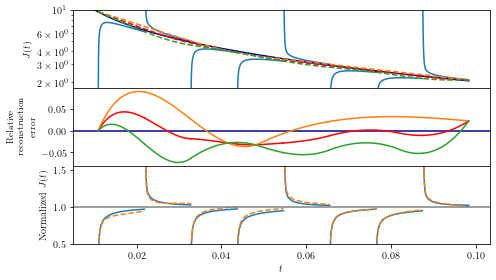

In [99]:
fig = plt.figure(figsize=figsize)
gs = gridspec.GridSpec(3, 1, height_ratios=[1, 1.0, 1])

ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1], sharex=ax0)
ax2 = plt.subplot(gs[2], sharex=ax0)

for i, d in enumerate(data_mov):
    if i == 0:
        ax0.plot(d[0], d[1], c="C0", label="")
    else:
        ax0.plot(d[0], d[1], c="C0")

for i, d in enumerate(data_imm):
    ax0.plot(d[0], d[1], c="darkblue")#, linestyle="dashdot")

ax0.plot(samples, f_mid(samples), "--", c="red")
ax0.plot(samples, f_up(samples), "--", c="C1")
ax0.plot(samples, f_down(samples), "--", c="C2")
        
ax0.set_yscale("log")
ax0.set_ylim(0.175e1, 0.1e2)
ax0.set_xlim(0.005)        

ax1.axhline(0.0, c="darkblue")
for i, d in enumerate(data_imm[1:]):
    ax1.plot(d[0], (f_mid(d[0]) - d[1]) / d[1], c="red")
    ax1.plot(d[0], (f_up(d[0]) - d[1]) / d[1], c="C1")
    ax1.plot(d[0], (f_down(d[0]) - d[1]) / d[1], c="C2")
#ax1.set_ylim(0.88, 1.12)
    
for i, d in enumerate(data_mov):
    if i == 0:
        ax2.plot(d[0], d[1] / data_imm[i+1][1], c="C0", label="")
        ax2.plot(d[0], d[1] / f_mid(d[0]), "--", c="C1", label="")
    else:
        ax2.plot(d[0], d[1] / data_imm[i+1][1], c="C0")
        ax2.plot(d[0], d[1] / f_mid(d[0]), "--", c="C1")
ax2.axhline(1.0, c="grey")
ax2.set_ylim(0.5, 1.55)

ax2.set_xlabel("$t$")
ax0.set_ylabel("$J(t)$")
ax1.set_ylabel("\\small{Relative}\n\\small{reconstruction}"+"\n"+"\small{error}")
ax2.set_ylabel("Normalized $J(t)$")

plt.tight_layout()
plt.setp(ax0.get_xticklabels(), visible=False)
plt.setp(ax1.get_xticklabels(), visible=False)
plt.subplots_adjust(hspace=.0)

plt.savefig(os.path.join(PATH+"the_interpolation.pdf"), dpi=DPI, pad_inches=0.0)

# EXTRACTING THE DATA FROM THE DICTIONARY

In [48]:
%matplotlib inline

In [4]:
import pickle

In [7]:
DATA_PATH = "/home/camontan/moving_barrier_data"

In [51]:
with open(os.path.join(DATA_PATH, 'processed_evolution_tiptap_only.pkl'), 'rb') as f:
    d = pickle.load(f)

In [52]:
mov = "the_steady_tip-tap_standard"

In [53]:
pos = []
rep = []
magic = []
pos_list = []
rep_list = []
magic_list = []

for i, p in enumerate(d[mov]):
    if i==0:
        for j, r in enumerate(d[mov][p]):
            if j==0:
                for k, m in enumerate(d[mov][p][r]):
                    magic.append(m)
                    magic_list.append(m)
            rep.append(r)
            rep_list.append(r)
    pos.append(p)
    pos_list.append(p)

In [54]:
pos

['avg', 'high', 'higher', 'low', 'lowlow', 'mid', 'over', 'same', 'ultra']

In [55]:
I_max_list = {
    p : d[mov][p][rep[1]]["main_info"]["I_max"] / d[mov][p][rep[1]]["main_info"]["I_star"]
    for p in pos
}

In [56]:
rep

['10', '1', '20', '2', '4', '50', '5']

In [57]:
I_max_list

{'avg': 0.3,
 'high': 0.75,
 'higher': 0.9,
 'low': 0.2,
 'lowlow': 0.1,
 'mid': 0.5,
 'over': 1.75,
 'same': 1.0,
 'ultra': 1.25}

In [58]:
magic

['main_info',
 'high_standard',
 'high_true',
 'high_true-delta',
 'high_true+delta',
 'low_standard',
 'low_true',
 'low_true-delta',
 'low_true+delta']

## Best ideal magic numbers

In [59]:
magic_data_high = {}
magic_data_low = {}

for r in rep:
    magic_data_high[r] = [[], []]
    magic_data_low[r] = [[], []]
    for p in I_max_list:
        magic_data_high[r][0].append(I_max_list[p])
        magic_data_high[r][1].append(float(d[mov][p][r]['high_true']['processed']["magic"]))
        magic_data_low[r][0].append(I_max_list[p])
        magic_data_low[r][1].append(float(d[mov][p][r]['low_true']['processed']["magic"]))
        

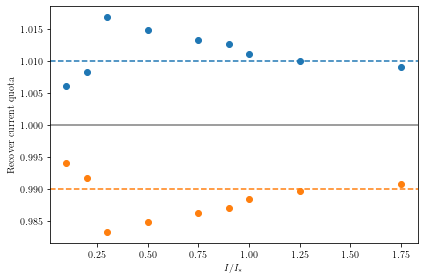

In [60]:
r = '5'
plt.scatter(magic_data_high[r][0], magic_data_high[r][1])
plt.scatter(magic_data_low[r][0], magic_data_low[r][1])

plt.axhline(1.0, c="grey")
plt.axhline(1.01, linestyle="dashed", c="C0")
plt.axhline(0.99, linestyle="dashed", c="C1")

plt.xlabel("$I/I_\\ast$")
plt.ylabel("Recover current quota")

plt.tight_layout()
plt.savefig(os.path.join(PATH+"magic_numbers.pdf"), dpi=DPI)

In [61]:
data = d[mov][pos][r]["main_info"]

TypeError: unhashable type: 'list'

In [ ]:
r = '5'
pos = 'avg'
post = 'processed'
I_star = d[mov][pos][r]["main_info"]["I_star"]

fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1])

axs = plt.subplot(gs[0])
axs1 = plt.subplot(gs[1], sharex=axs)

x = (d[mov][pos][r][m][post]["val"])
y_standard = (d[mov][pos][r]['high_standard'][post]["avg"])
y_ideal = (d[mov][pos][r]['high_true'][post]["avg"])

y_afpt = (d[mov][pos][r][m][post]["afpt"])

#### OKKIO QUA!!!! ###
axs.scatter(x / I_star, y_standard, label="Standard recover point: {:.4}".format(float(d[mov][pos][r]['high_standard'][post]["magic"]) - 0.01))
axs.scatter(x / I_star, y_ideal, marker="*", label="Ideal recover point: {:.4}".format(float(d[mov][pos][r]['high_true'][post]["magic"])))
axs.scatter(x / I_star, y_afpt, label="Average First Passage Time", marker="x", color="black")

axs1.scatter(x / I_star, y_standard / y_standard[0])
axs1.scatter(x / I_star, y_ideal / y_ideal[0], marker="*")
axs1.scatter(x / I_star, y_afpt / y_afpt[0], marker="x", color="black")

y_test = np.array([nt.D(x[i], data["I_star"], data["exponent"], data["c"]) for i in range(len(x))])
y_test = 1/y_test
axs1.scatter(x / I_star, y_test / y_test[1], marker="x", color="grey", label="Normalized $1/D(I)$")
######################

axs.legend()
axs1.legend()
axs.set_ylabel("Recover time")
axs1.set_ylabel("Relative recover time")
axs1.set_xlabel("$I_a / I_*$")

plt.tight_layout()
plt.subplots_adjust(hspace=.0)
plt.setp(ax0.get_xticklabels(), visible=False)

plt.savefig(os.path.join(PATH+"recover_times.pdf"), dpi=DPI)

In [ ]:
fig = plt.figure(figsize=(7,4))
gs = gridspec.GridSpec(2, 2, width_ratios=[1, 1], height_ratios=[1, 1])

axs = plt.subplot(gs[0])
axs1 = plt.subplot(gs[2], sharex=axs)

axs2 = plt.subplot(gs[1])
axs3 = plt.subplot(gs[3], sharex=axs2)

r = '5'
pos = 'lowlow'
post = 'processed'
I_star = d[mov][pos][r]["main_info"]["I_star"]

x = (d[mov][pos][r][m][post]["val"])
y_standard = (d[mov][pos][r]['high_standard'][post]["avg"])
y_ideal = (d[mov][pos][r]['high_true'][post]["avg"])

y_afpt = (d[mov][pos][r][m][post]["afpt"])

#### OKKIO QUA!!!! ###
axs.scatter(x / I_star, y_standard, label="Standard recover point: {:.4}".format(float(d[mov][pos][r]['high_standard'][post]["magic"]) - 0.01))
axs.scatter(x / I_star, y_ideal, marker="*", label="Ideal recover point: {:.4}".format(float(d[mov][pos][r]['high_true'][post]["magic"])))
axs.scatter(x / I_star, y_afpt, label="Average First Passage Time", marker="x", color="black")

axs1.scatter(x / I_star, y_standard / y_standard[0])
axs1.scatter(x / I_star, y_ideal / y_ideal[0], marker="*")
axs1.scatter(x / I_star, y_afpt / y_afpt[0], marker="x", color="black")

y_test = np.array([nt.D(x[i], data["I_star"], data["exponent"], data["c"]) for i in range(len(x))])
y_test = 1/y_test
axs1.scatter(x / I_star, y_test / y_test[1], marker="x", color="grey", label="Normalized $1/D(I)$")
######################

r = '5'
pos = 'high'
post = 'processed'
I_star = d[mov][pos][r]["main_info"]["I_star"]

x = (d[mov][pos][r][m][post]["val"])
y_standard = (d[mov][pos][r]['high_standard'][post]["avg"])
y_ideal = (d[mov][pos][r]['high_true'][post]["avg"])

y_afpt = (d[mov][pos][r][m][post]["afpt"])

#### OKKIO QUA!!!! ###
axs2.scatter(x / I_star, y_standard, label="Standard recover point: {:.4}".format(float(d[mov][pos][r]['high_standard'][post]["magic"]) - 0.01))
axs2.scatter(x / I_star, y_ideal, marker="*", label="Ideal recover point: {:.4}".format(float(d[mov][pos][r]['high_true'][post]["magic"])))
axs2.scatter(x / I_star, y_afpt, label="Average First Passage Time", marker="x", color="black")

axs3.scatter(x / I_star, y_standard / y_standard[0])
axs3.scatter(x / I_star, y_ideal / y_ideal[0], marker="*")
axs3.scatter(x / I_star, y_afpt / y_afpt[0], marker="x", color="black")

y_test = np.array([nt.D(x[i], data["I_star"], data["exponent"], data["c"]) for i in range(len(x))])
y_test = 1/y_test
axs3.scatter(x / I_star, y_test / y_test[1], marker="x", color="grey", label="Normalized $1/D(I)$")
######################

axs.legend(fontsize="xx-small")
axs1.legend(fontsize="xx-small")
axs.set_ylabel("Recover time")
axs1.set_ylabel("Relative\nrecover time")
axs1.set_xlabel("$I_a / I_*$")
axs3.set_xlabel("$I_a / I_*$")

plt.tight_layout()
plt.subplots_adjust(hspace=.0)
#plt.subplots_adjust(wspace=.0)
plt.setp(axs.get_xticklabels(), visible=False)
plt.setp(axs2.get_xticklabels(), visible=False)
#plt.setp(axs2.get_yticklabels(), visible=False)
#plt.setp(axs3.get_yticklabels(), visible=False)
plt.savefig(os.path.join(PATH+"recover_times_multiple.pdf"), dpi=DPI)

# Fit Results

In [62]:
rep = '5'
pos = 'lowlow'
post = 'processed'

In [63]:
data = d[mov][pos][rep]["main_info"]

In [64]:
params = lmfit.Parameters()
params.add("I_star", data["I_star"], min=0.0)
params.add("exponent", data["exponent"], min=0.0)
params.add("c", data["c"], vary=False)

In [65]:
def resid(params, xdata, ydata):
    I_star = params["I_star"]
    exponent = params["exponent"]
    c = params["c"]
    I_low = [x[0] for x in xdata]
    I_high = [x[1] for x in xdata]
    afpt = np.array([
        nt.afpt(
            I_low[i],
            I_high[i],
            I_star,
            exponent,
            c
    ) for i in range(len(I_low))])
    if np.any(np.isnan(afpt)) or np.any(np.isinf(afpt)):
        print("BAD STUFF!")
        return np.ones_like(ydata) * 1e6
    return afpt - ydata

In [66]:
mov = 'the_steady_tip-tap_standard'
rep = '10'
post = 'processed'

In [67]:
x_vals = []

kappa_standard = []
kappa_ideal = []

I_star_standard = []
I_star_ideal = []

for p in tqdm(pos_list):
    x_vals.append(I_max_list[p])

    data = d[mov][p][rep]["main_info"]
    sample = d[mov][p][rep]["high_true"][post]
    sample_standard = d[mov][p][rep]["high_standard"][post]

    params = lmfit.Parameters()
    params.add("I_star", data["I_star"], min=0.0)
    params.add("exponent", data["exponent"], min=0.0)
    params.add("c", data["c"], vary=False)

    fit_data_ideal = lmfit.minimize(
        resid,
        params,
        args=(
            list(zip(
                sample["val"] - data["step_size"],
                sample["val"]
            )),
            sample["avg"]
        ),
        method="leastsq"
    )
    kappa_ideal.append(fit_data_ideal.params["exponent"].value)
    I_star_ideal.append(fit_data_ideal.params["I_star"].value)

    params = lmfit.Parameters()
    params.add("I_star", data["I_star"], min=0.0)
    params.add("exponent", data["exponent"], min=0.0)
    params.add("c", data["c"], vary=False)

    fit_data_standard = lmfit.minimize(
        resid,
        params,
        args=(
            list(zip(
                sample_standard["val"] - data["step_size"],
                sample_standard["val"]
            )),
            sample_standard["avg"]
        ),
        method="leastsq"
    )
    kappa_standard.append(fit_data_standard.params["exponent"].value)
    I_star_standard.append(fit_data_standard.params["I_star"].value)

    
kappa_standard = 1 / np.asarray(kappa_standard) / 2
kappa_ideal = 1 / np.asarray(kappa_ideal) / 2

I_star_standard = np.asarray(I_star_standard)
I_star_ideal = np.asarray(I_star_ideal)


  0%|          | 0/9 [00:00<?, ?it/s]

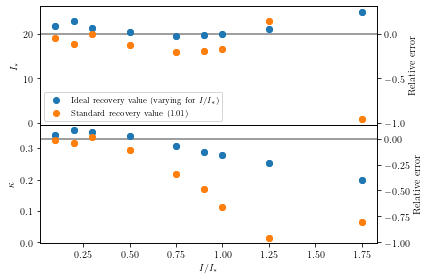

In [68]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

ax1_bis = ax1.twinx()
ax2_bis = ax2.twinx()

ax1.scatter(x_vals, I_star_ideal, label='Ideal recovery value (varying for $I/I_\\ast$)')
ax1_bis.scatter(x_vals, (I_star_ideal-data["I_star"])/data["I_star"])
ax1.scatter(x_vals, I_star_standard, label="Standard recovery value (1.01)")
ax1_bis.scatter(x_vals, (I_star_standard-data["I_star"])/data["I_star"], label="")

ax1.legend(fontsize="small")
ax1.axhline(data["I_star"], color="grey")
ax1.set_ylabel("$I_*$")
ax1_bis.set_ylabel("Relative error")

ax2.scatter(x_vals, kappa_ideal)
ax2.scatter(x_vals, kappa_standard)
ax2_bis.scatter(x_vals, (kappa_ideal-data["k"])/data["k"])
ax2_bis.scatter(x_vals, (kappa_standard-data["k"])/data["k"])

ax2.axhline(data["k"], color="grey")
ax2.set_ylabel("$\\kappa$")
ax2_bis.set_ylabel("Relative error")
ax2.set_xlabel("$I/I_*$")

plt.tight_layout()
plt.subplots_adjust(hspace=.0)
plt.setp(ax0.get_xticklabels(), visible=False)

plt.savefig(os.path.join(PATH+"high_fits.pdf"), dpi=DPI)

In [69]:
x_vals = []

kappa_standard = []
kappa_ideal = []

I_star_standard = []
I_star_ideal = []

for p in tqdm(pos_list):
    x_vals.append(I_max_list[p])

    data = d[mov][p][rep]["main_info"]
    sample = d[mov][p][rep]["low_true"][post]
    sample_standard = d[mov][p][rep]["low_standard"][post]

    params = lmfit.Parameters()
    params.add("I_star", data["I_star"], min=0.0)
    params.add("exponent", data["exponent"], min=0.0)
    params.add("c", data["c"], vary=False)

    fit_data_ideal = lmfit.minimize(
        resid,
        params,
        args=(
            list(zip(
                sample["val"],
                sample["val"] + data["step_size"]
            )),
            sample["avg"]
        ),
        method="leastsq"
    )
    kappa_ideal.append(fit_data_ideal.params["exponent"].value)
    I_star_ideal.append(fit_data_ideal.params["I_star"].value)

    params = lmfit.Parameters()
    params.add("I_star", data["I_star"], min=0.0)
    params.add("exponent", data["exponent"], min=0.0)
    params.add("c", data["c"], vary=False)

    fit_data_standard = lmfit.minimize(
        resid,
        params,
        args=(
            list(zip(
                sample_standard["val"],
                sample_standard["val"] + data["step_size"]
            )),
            sample_standard["avg"]
        ),
        method="leastsq"
    )
    kappa_standard.append(fit_data_standard.params["exponent"].value)
    I_star_standard.append(fit_data_standard.params["I_star"].value)

kappa_standard = 1 / np.asarray(kappa_standard) / 2
kappa_ideal = 1 / np.asarray(kappa_ideal) / 2

I_star_standard = np.asarray(I_star_standard)
I_star_ideal = np.asarray(I_star_ideal)


  0%|          | 0/9 [00:00<?, ?it/s]

### Plot (Low)

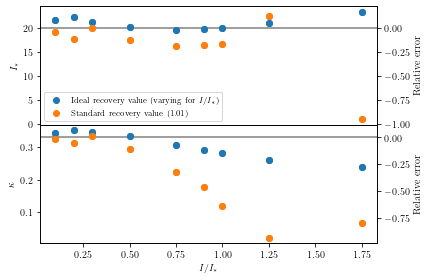

In [70]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

ax1_bis = ax1.twinx()
ax2_bis = ax2.twinx()

ax1.scatter(x_vals, I_star_ideal, label='Ideal recovery value (varying for $I/I_\\ast$)')
ax1_bis.scatter(x_vals, (I_star_ideal-data["I_star"])/data["I_star"])
ax1.scatter(x_vals, I_star_standard, label="Standard recovery value (1.01)")
ax1_bis.scatter(x_vals, (I_star_standard-data["I_star"])/data["I_star"], label="")

ax1.legend(fontsize="small")
ax1.axhline(data["I_star"], color="grey")
ax1.set_ylabel("$I_*$")
ax1_bis.set_ylabel("Relative error")

ax2.scatter(x_vals, kappa_ideal)
ax2.scatter(x_vals, kappa_standard)
ax2_bis.scatter(x_vals, (kappa_ideal-data["k"])/data["k"])
ax2_bis.scatter(x_vals, (kappa_standard-data["k"])/data["k"])

ax2.axhline(data["k"], color="grey")
ax2.set_ylabel("$\\kappa$")
ax2_bis.set_ylabel("Relative error")
ax2.set_xlabel("$I/I_*$")

plt.tight_layout()
plt.subplots_adjust(hspace=.0)
plt.setp(ax0.get_xticklabels(), visible=False)

plt.savefig(os.path.join(PATH+"low_fits.pdf"), dpi=DPI)

# Schema

In [16]:
%matplotlib widget

In [13]:
with open(os.path.join(DATA_PATH, "data_avg_I_a_4_r_10_the_steady_tip-tap_reverse_standard.pkl"), 'rb') as f:
    all_data = pickle.load(f)

In [14]:
all_data[2][0].keys()

dict_keys(['I_max_before', 'I_max_high', 'I_max_after', 'I_max_low', 't_absolute', 't_relative', 'current', 'current_ana'])

In [18]:
fig = plt.figure()#(figsize=(5, 3))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 0.3])

ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1], sharex=ax0)

for d in tqdm(all_data[2][:len(all_data[2])//5]):
    ax1.plot(
        [d["t_absolute"][0], d["t_absolute"][0], d["t_absolute"][-1]],
        np.asarray([d["I_max_before"], d["I_max_after"], d["I_max_after"]])/all_data[0]["I_star"], c="black")
    ax0.plot(d["t_absolute"], d["current"], c="C0")
    ax0.plot(d["t_absolute"], d["current_ana"], "--", c="C1")
    
ax0.set_yscale("log")

ax1.set_xlabel("$t$")
ax0.set_ylabel("$J$")
ax1.set_ylabel("$I_a/I_\\ast$")

plt.tight_layout()
plt.subplots_adjust(hspace=.0)
plt.setp(ax0.get_xticklabels(), visible=False)
#ax0.set_xlim(0, 800)

plt.savefig(os.path.join(PATH+"raw_process.pdf"), dpi=DPI)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

  0%|          | 0/50 [00:00<?, ?it/s]

In [86]:
plt.close("all")

# MULTPLE CURVES

In [5]:
%matplotlib widget

In [6]:
mov = "the_steady_tip-tap_standard"
pos = "avg"
rep = "5"

In [7]:
with open(os.path.join(DATA_PATH, "data_{}_I_a_4_r_{}_the_steady_tip-tap_standard.pkl".format(pos, rep)), 'rb') as f:
    all_data = pickle.load(f)
multiple_data_file_low = "data_{}_I_a_4_r_{}_the_steady_tip-tap_standard_low_avg.pkl".format(pos, rep)
multiple_data_file_high = "data_{}_I_a_4_r_{}_the_steady_tip-tap_standard_high_avg.pkl".format(pos, rep)

In [8]:
with open(os.path.join(DATA_PATH, multiple_data_file_low), 'rb') as f:
    d_low = pickle.load(f)

with open(os.path.join(DATA_PATH, multiple_data_file_high), 'rb') as f:
    d_high = pickle.load(f)

In [9]:
all_data[0].keys()

dict_keys(['I_star', 'k', 'cn_sampling', 'dt_sampling', 'steps_in_I', 'relax_samples', 'relaxing_samples', 'it_per_sample', 'name', 'I_max', 'step_size', 'I_damping', 'sub_name', 'repetitions', 'samples', 'exponent', 'c', 'dt', 'protocol_name'])

In [10]:
all_data[2][0].keys()

dict_keys(['I_max_before', 'I_max_high', 'I_max_after', 'I_max_low', 't_absolute', 't_relative', 'current'])

In [11]:
d_low.keys()

dict_keys([6.0, 6.010201020102009, 6.020402040204019, 6.030603060306028, 6.040804080408037, 6.0510051005100465, 6.061206120612056, 6.071407140714065, 6.081608160816074, 6.091809180918084, 6.102010201020093, 6.112211221122102, 6.1224122412241115, 6.132613261326121, 6.14281428142813, 6.153015301530139, 6.163216321632149, 6.173417341734158, 6.183618361836167, 6.193819381938177, 6.204020402040186, 6.214221422142195, 6.2244224422442045, 6.234623462346214, 6.244824482448223, 6.255025502550232, 6.265226522652242, 6.275427542754251, 6.28562856285626, 6.2958295829582696, 6.306030603060279, 6.316231623162288, 6.326432643264297, 6.336633663366307, 6.346834683468316, 6.357035703570325, 6.367236723672335, 6.377437743774344, 6.387638763876353, 6.3978397839783625, 6.408040804080372, 6.418241824182381, 6.42844284428439, 6.4386438643864, 6.448844884488409, 6.459045904590418, 6.469246924692428, 6.479447944794437, 6.489648964896446, 6.4998499849984555])

In [12]:
d_low[list(d_low.keys())[1]].keys()#['mid'].keys()

dict_keys(['mid', 'high', 'low', 'true', 'time'])

In [13]:
list(d_high.keys())[1]

6.020402040204019

In [14]:
idx1 = 1
idx2 = 15
idx3 = 30

In [15]:
all_data[0].keys()

dict_keys(['I_star', 'k', 'cn_sampling', 'dt_sampling', 'steps_in_I', 'relax_samples', 'relaxing_samples', 'it_per_sample', 'name', 'I_max', 'step_size', 'I_damping', 'sub_name', 'repetitions', 'samples', 'exponent', 'c', 'dt', 'protocol_name'])

In [16]:
def compute_block(a, b, I_star, exponent, c):
    return scipy.integrate.quad(
        lambda x : 1 / nt.D(x, I_star, exponent, c),
        a,
        b
    )[0]

def preliminary_fit(data_fit, data_real):
    popt, _ = scipy.optimize.curve_fit(
        lambda x, par: np.log10(par * x),
        data_fit,
        np.log10(data_real)
    )
    return popt[0]


In [17]:
idx1 = 1
dx_limit = 50000
skipper = 200

sampled_time = d_high[list(d_high.keys())[1]]["time"][:dx_limit:skipper]

module = compute_block(
    list(d_high.keys())[idx1],
    list(d_high.keys())[idx1] + all_data[0]["step_size"],
    all_data[0]["I_star"], all_data[0]["exponent"], all_data[0]["c"]
)

current_unitary = nt.current_generic(
    sampled_time,
    lambda x : module,
    list(d_high.keys())[idx1],
    list(d_high.keys())[idx1] - 4.0,
    all_data[0]["I_star"], all_data[0]["exponent"], all_data[0]["c"]
)

real_module = preliminary_fit(current_unitary, d_high[list(d_high.keys())[idx1]]["true"]['avg'][:dx_limit:skipper] - 1)

print(module)
print(real_module)

0.002622900758961161
1.8782251944394597


In [100]:
print(len(d_high[list(d_high.keys())[1]]["time"]))

dx_limit = 50000
skipper = 200

sampled_time = d_high[list(d_high.keys())[1]]["time"][:dx_limit:skipper]


module = compute_block(
    list(d_high.keys())[idx1], 
    list(d_high.keys())[idx1] + all_data[0]["step_size"],
    all_data[0]["I_star"], all_data[0]["exponent"], all_data[0]["c"]
)
current_approx = nt.current_generic(
    sampled_time, 
    lambda x : module, 
    list(d_high.keys())[idx1], 
    list(d_high.keys())[idx1] - 2.0, 
    all_data[0]["I_star"], all_data[0]["exponent"], all_data[0]["c"]
)

module = compute_block(
    list(d_high.keys())[idx2], 
    list(d_high.keys())[idx2] + all_data[0]["step_size"], 
    all_data[0]["I_star"], all_data[0]["exponent"], all_data[0]["c"]
)
current_approx_2 = nt.current_generic(
    sampled_time, 
    lambda x : module, 
    list(d_high.keys())[idx2], 
    list(d_high.keys())[idx2] - 2.0, 
    all_data[0]["I_star"], all_data[0]["exponent"], all_data[0]["c"]
)

module = compute_block(
    list(d_high.keys())[idx3], 
    list(d_high.keys())[idx3] + all_data[0]["step_size"], 
    all_data[0]["I_star"], all_data[0]["exponent"], all_data[0]["c"]
)
current_approx_3 = nt.current_generic(
    sampled_time, 
    lambda x : module, 
    list(d_high.keys())[idx3], 
    list(d_high.keys())[idx3] - 2.0, 
    all_data[0]["I_star"], all_data[0]["exponent"], all_data[0]["c"]
)

100000


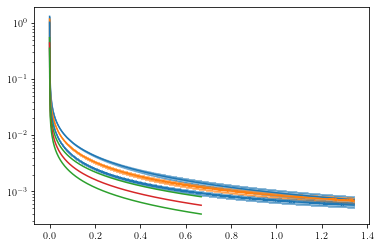

In [101]:
plt.figure()

plt.plot(
    d_high[list(d_high.keys())[idx1]]["time"],
    d_high[list(d_high.keys())[idx1]]["true"]['avg'] - 1,
    color="C0"
)
plt.fill_between(
    d_high[list(d_high.keys())[idx1]]["time"], d_high[list(d_high.keys())[idx1]]["true"]['avg'] - 1 - d_high[list(d_high.keys())[idx1]]["true"]['std'],
    d_high[list(d_high.keys())[idx1]]["true"]['avg'] - 1 + d_high[list(d_high.keys())[idx1]]["true"]['std'],
    color="C0", alpha=0.5
)


plt.plot(
    d_high[list(d_high.keys())[idx2]]["time"],
    d_high[list(d_high.keys())[idx2]]["true"]['avg'] - 1,
    color="C1"
)
plt.fill_between(
    d_high[list(d_high.keys())[idx2]]["time"], d_high[list(d_high.keys())[idx2]]["true"]['avg'] - 1 - d_high[list(d_high.keys())[idx2]]["true"]['std'],
    d_high[list(d_high.keys())[idx2]]["true"]['avg'] - 1 + d_high[list(d_high.keys())[idx2]]["true"]['std'],
    color="C1", alpha=0.5
)


plt.plot(
    d_high[list(d_high.keys())[idx3]]["time"],
    d_high[list(d_high.keys())[idx3]]["true"]['avg'] - 1,
    color="C0"
)
plt.fill_between(
    d_high[list(d_high.keys())[idx3]]["time"], d_high[list(d_high.keys())[idx3]]["true"]['avg'] - 1 - d_high[list(d_high.keys())[idx3]]["true"]['std'],
    d_high[list(d_high.keys())[idx3]]["true"]['avg'] - 1 + d_high[list(d_high.keys())[idx3]]["true"]['std'],
    color="C0", alpha=0.5
)

plt.plot(sampled_time, current_approx, c="C2")
plt.plot(sampled_time, current_approx_2, c="C3")
plt.plot(sampled_time, current_approx_3, c="C2")

plt.yscale("log")
#plt.xlim(right=0.4)


In [102]:
"""
def resid(params, x, y):
    I_star = params["I_star"]
    exponent = params["exponent"]
    c = params["c"]

    t = [x[0] for x in x]
    D_loc = [x[1] for x in x]
    D_list = [compute_block(I, I + all_data[0]["step_size"], I_star, exponent, c) for I in D_loc]
    D_rep = [D_list[0] / D_list[i] for i in range(len(D_list))]
    print(I_star.value, exponent.value, c.value)
    currents = []
    currents.append(np.array(nt.current_generic(
        t[0],
        lambda l : 1.0,
        D_loc[0], D_loc[0] - 2.0,
        I_star.value, exponent.value, c.value
    )))
    multiplier = preliminary_fit(currents[0], y[0])
    currents[0] *= multiplier
    for i in range(1, len(D_rep)):
        currents.append(np.array(nt.current_generic(
            t[i],
            lambda l : multiplier * D_rep[i],
            D_loc[i], D_loc[i] - 2.0,
            I_star.value, exponent.value, c.value
        )))

    return np.log10(np.concatenate(currents)) - np.log10(np.concatenate(y))
"""


def resid(params, x, y):
    I_star = params["I_star"]
    exponent = params["exponent"]
    c = params["c"]

    t = [x[0] for x in x]
    D_loc = [x[1] for x in x]
    D_list = [compute_block(I, I + all_data[0]["step_size"], I_star, exponent, c) for I in D_loc]
    print(I_star.value, exponent.value, c.value)
    currents = []
    for i in range(len(D_list)):
        currents.append(np.array(nt.current_generic(
            t[i],
            lambda l : D_list[i],
            D_loc[i], D_loc[i] - 3.0,
            I_star.value, exponent.value, c.value
        )))

    return np.log10(np.concatenate(currents)) - np.log10(np.concatenate(y))

def general_fit(x_data, y_data, starting_pars):
    params = lmfit.Parameters()
    params.add("I_star", starting_pars["I_star"], min=0.0)
    params.add("exponent", starting_pars["exponent"], min=0.0)
    params.add("c", starting_pars["c"], vary=False)

    fit = lmfit.minimize(
        resid,
        params,
        args=(x_data, y_data),
        method="leastsq"
    )
    
    return fit
    
low_idx = 1
high_idx = 40
jump_idx = 5

dx_limit = 40000
skipper = 1000

sampled_time = d_high[list(d_high.keys())[1]]["time"][:dx_limit:skipper]

x = [(sampled_time, list(d_high.keys())[i]) for i in range(low_idx, high_idx, jump_idx)]
y = [d_high[list(d_high.keys())[i]]["true"]['avg'][:dx_limit:skipper] - 1 for i in range(low_idx, high_idx, jump_idx)]
starting_pars = {
    "I_star":all_data[0]["I_star"],
    "exponent":all_data[0]["exponent"],# - all_data[0]["exponent"] * 0.1,
    "c":all_data[0]["c"],
}


fit = general_fit(x, y, starting_pars)
fit

20.0 1.5151515151515156 851658.9385540067
20.0 1.5151515151515156 851658.9385540067
20.0 1.5151515151515156 851658.9385540067
20.000000312214805 1.5151515151515156 851658.9385540067
20.0 1.5151515467056353 851658.9385540067
22.23943677598916 1.435149092697468 851658.9385540067
22.23943712164255 1.435149092697468 851658.9385540067
22.23943677598916 1.4351491228648183 851658.9385540067
22.55997857737371 1.432899917605552 851658.9385540067
22.55997892781227 1.432899917605552 851658.9385540067
22.55997857737371 1.43289994773373 851658.9385540067
22.628958259976052 1.429585871979075 851658.9385540067
22.62895861144434 1.429585871979075 851658.9385540067
22.628958259976052 1.4295859020495154 851658.9385540067
22.623147522921112 1.4298913880530857 851658.9385540067
22.623147874302656 1.4298913880530857 851658.9385540067
22.623147522921112 1.4298914181288493 851658.9385540067
22.623854027670067 1.4298559497147223 851658.9385540067
22.623854027670067 1.4298559497147223 851658.9385540067


In [103]:
fit.params["I_star"].value

22.623854027670067

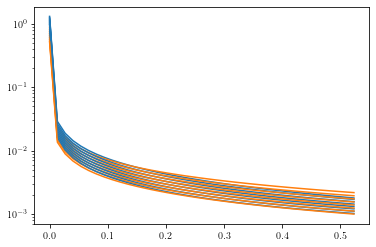

In [104]:
plt.figure()
for i in range(low_idx, high_idx, jump_idx):
    plt.plot(
        d_high[list(d_high.keys())[i]]["time"][:dx_limit:skipper],
        d_high[list(d_high.keys())[i]]["true"]['avg'][:dx_limit:skipper] - 1,
        color="C0"
    )
    module = compute_block(
        list(d_high.keys())[i],
        list(d_high.keys())[i] + all_data[0]["step_size"],
        fit.params["I_star"].value, fit.params["exponent"].value, fit.params["c"].value
    )

    current_unitary = nt.current_generic(
        sampled_time,
        lambda x : module,
        list(d_high.keys())[i],
        list(d_high.keys())[i] - 4.0,
        fit.params["I_star"].value, fit.params["exponent"].value, fit.params["c"].value
    )
    
    plt.plot(sampled_time, current_unitary, c="C1")

plt.yscale("log")

In [54]:
val = preliminary_fit(current_approx, d_high[list(d_high.keys())[idx1]]["true"]['avg'][:dx_limit:skipper] - 1)

plt.figure()
plt.plot(np.asarray(current_approx) * val)
plt.plot(d_high[list(d_high.keys())[idx1]]["true"]['avg'][:dx_limit:skipper] - 1)
plt.yscale("log")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [85]:
plt.figure()

cmap = matplotlib.cm.get_cmap('viridis')
for i, key in list(enumerate(d_high)):
    idx = i / len(d_high)
    plt.plot(d_high[key]['time'], d_high[key]['true']['avg'] - 1.0, c=cmap(idx))

#plt.xscale("log")
plt.yscale("log")
plt.xlim(0, 0.2)
plt.axhline(0.01, c="grey", label="0.01")

plt.legend()
plt.xlabel("Time")
plt.ylabel("Recover current\n[(real current / immovable current) - 1]")

plt.title("Recover current analysis")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0.5, 1.0, 'Recover current analysis')

# USELESS STUFF

## 3 - Semi-ideal reconstruction

This is the **core experiment** I will discuss most in the paper, so everything must be perfect!

### First, we need to define a realistic initial distribution

It's very simple and direct: if we decide to work in normalized emittance variables, and we work with a gaussian beam distribution with it's characteristic emittance, we have that
$$\rho_0(I) = e^{-I}$$
Where $I$, from now on, is expessed in sigma units.

In [ ]:
def rho_0(I, damping_position=np.nan, l=np.nan):
    if np.isnan(damping_position) or np.isnan(l):
        return np.exp(-I)
    else:
        return np.exp(-I) / (1 + np.exp((I - damping_position)/l))

### Setting up the scenario

In [ ]:
I_damping = 1.9
I_max = 2.0
I_star = 10.0
k = 0.33
exponent = 1/(2*k)

# As for the time scaling... we go with this one.
# REMEMBER TO SPECIFY IT PROPERLY IN THE PAPER!!!
c = nt.standard_c(0.0, I_max, I_star, exponent)

In [ ]:
cn_sampling = 10000
I_list, dI = np.linspace(0.0, I_max, cn_sampling, retstep=True)

cn_time_steps = 100
dt = nt.current_peak_time(I_damping, I_max, I_star, exponent, c)/cn_time_steps

In [ ]:
steps_per_sample = 5

steps_per_iteration = 10000
iterations = 10
macro_iterations = 5
long_track_steps = steps_per_iteration * iterations * (macro_iterations + 1)

In [ ]:
engine = cn.cn_generic(0, I_max, rho_0(I_list, I_damping, dI*5), dt, lambda x: nt.D(x, I_star, exponent, c, True))
data_0 = engine.get_data_with_x()

times_long, current_long = engine.current(long_track_steps, steps_per_sample, False)
data_long = engine.get_data_with_x()

In [ ]:
plt.figure()
plt.plot(data_0[0], data_0[1], label="Initial condition")
plt.plot(data_long[0], data_long[1], label="After iterations")
plt.axvline(I_max, color="black", label="$I_a$")
plt.xlabel("$I$")
plt.ylabel("$\\rho$")
plt.legend()

**And here's the current!**

In [ ]:
plt.figure()
plt.plot(times_long, current_long)
plt.xlabel("$t$")
plt.ylabel("$J$")
plt.yscale("log")

In [ ]:
engine = cn.cn_generic(0, I_max, rho_0(I_list, I_damping, dI*5), dt, lambda x: nt.D(x, I_star, exponent, c, True))

t_absolute_out = []
t_relative_out = []
c_out = []
I_max_list = []
set_list = []

t_absolute_out_partial = []
t_relative_out_partial = []
c_out_partial = []
I_max_list_partial = []
set_list_partial = []

for j in tqdm(range(macro_iterations + 1)):
    if j != 0:
        engine.move_barrier_backward(0.1 * iterations)

    for i in tqdm(range(iterations)):
        time, current = engine.current(steps_per_iteration, steps_per_sample)
        if len(t_absolute_out) > 0:
            absolute_time = time + t_absolute_out[-1][-1]
        else:
            absolute_time = time.copy()
        t_relative_out.append(time)
        t_absolute_out.append(absolute_time)
        c_out.append(current)
        I_max_list.append(engine.I_max)
        set_list.append(i)
        if i != 0:
            t_relative_out_partial.append(time)
            t_absolute_out_partial.append(absolute_time)
            c_out_partial.append(current)
            I_max_list_partial.append(engine.I_max)
            set_list_partial.append(i)
        engine.move_barrier_forward(0.1)

In [ ]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
for i in range(len(t_absolute_out)):
    ax2.plot(
        [t_absolute_out[i][0],t_absolute_out[i][-1], t_absolute_out[i][-1]],
        [I_max_list[i],I_max_list[i],(I_max_list[i+1] if i+1 != len(I_max_list) else I_max_list[i])],
        c="black", alpha=0.5
    )
    ax1.plot(t_absolute_out[i], c_out[i])
    if i != len(t_absolute_out) - 1:
        ax1.plot(
            [t_absolute_out[i][-1], t_absolute_out[i][-1]],
            [c_out[i][-1], c_out[i+1][0]],
            c="black"
        )

ax1.plot(times_long, current_long, c="C0", linestyle="dashed")

ax1.set_yscale("log")
ax1.set_ylabel("Current")
ax1.set_xlabel("time")
ax2.set_ylabel("Barrier position")

In [ ]:
fig, ax1 = plt.subplots()

slice_size = len(current_long) // len(t_absolute_out)

c_normalized_out = []
c_normalized_out_partial = []

ax2 = ax1.twinx()
for i in range(len(t_absolute_out)):
    ax2.plot(
        [t_absolute_out[i][0],t_absolute_out[i][-1], t_absolute_out[i][-1]],
        [I_max_list[i],I_max_list[i],(I_max_list[i+1] if i+1 != len(I_max_list) else I_max_list[i])],
        c="black", alpha=0.5
    )
    ax1.plot(t_absolute_out[i], c_out[i]/(current_long[slice_size * i:slice_size * (i+1)]))
    c_normalized_out.append(c_out[i]/(current_long[slice_size * i:slice_size * (i+1)]))
    if i != len(t_absolute_out) - 1:
        ax1.plot(
            [t_absolute_out[i][-1], t_absolute_out[i][-1]],
            np.array([c_out[i][-1], c_out[i+1][0]])/current_long[slice_size*(i+1)],
            c="black"
        )

#ax1.plot(times_long, current_long, c="C0", linestyle="dashed")

#ax1.set_yscale("log")
ax1.set_ylabel("`Normalized` Current")
ax1.set_xlabel("time")
ax2.set_ylabel("Barrier position")

In [ ]:
plt.figure()
for i in range(1, len(c_normalized_out)):
    if i%iterations==1 and i != 1:
        plt.plot(t_absolute_out[0], c_out[i], c="C0")
    elif i%iterations==2 and i != 2:
        plt.plot(t_absolute_out[0], c_out[i], c="C1")
    elif i%iterations==3 and i != 3:
        plt.plot(t_absolute_out[0], c_out[i], c="C2")
    elif i%iterations==4 and i != 4:
        plt.plot(t_absolute_out[0], c_out[i], c="C3")
    elif i%iterations==5 and i != 5:
        plt.plot(t_absolute_out[0], c_out[i], c="C4")
    else:
        pass
    
plt.xscale("log")

In [ ]:
plt.figure()
for i in range(1, len(c_normalized_out)):
    if i%iterations==1:# and i != 1:
        plt.plot(t_absolute_out[0], c_normalized_out[i], c="C0")
    elif i%iterations==2:# and i != 2:
        plt.plot(t_absolute_out[0], c_normalized_out[i], c="C1")
    elif i%iterations==3:# and i != 3:
        plt.plot(t_absolute_out[0], c_normalized_out[i], c="C2")
    elif i%iterations==4:# and i != 4:
        plt.plot(t_absolute_out[0], c_normalized_out[i], c="C3")
    elif i%iterations==5:# and i != 5:
        plt.plot(t_absolute_out[0], c_normalized_out[i], c="C4")
    else:
        pass
    
plt.axvline(afpt(I_max_list[0], I_max_list[1], I_star, exponent, c), c="C0")
plt.axvline(afpt(I_max_list[1], I_max_list[2], I_star, exponent, c), c="C1")
plt.axvline(afpt(I_max_list[2], I_max_list[3], I_star, exponent, c), c="C2")
plt.axvline(afpt(I_max_list[3], I_max_list[4], I_star, exponent, c), c="C3")
plt.axvline(afpt(I_max_list[4], I_max_list[5], I_star, exponent, c), c="C4")

plt.xscale("log")
plt.ylim(0.8,1.0)

fit!

In [ ]:
def the_func(x_list, I_star, exponent):
    print(I_star, exponent)
    I_start  = [x[0] for x in x_list]
    I_end = [x[1] for x in x_list]
    
    t_list = np.array([afpt(I_start[i], I_end[i], I_star, exponent, c) for i in range(len(I_start))])
    return t_list

In [ ]:
selected_times = []
x_list = []

for i in range(len(c_normalized_out)):
    if i%iterations!=0:
        selected_times.append(
            t_absolute_out[0][
                np.argmin(np.absolute(c_normalized_out[i] - 0.96))
            ]
        )
        x_list.append(
            (I_max_list[i-1], I_max_list[i])
        )

In [ ]:
plt.plot(selected_times)
plt.yscale("log")

In [ ]:
plt.plot(x_list)

In [ ]:
popt, pcov = scipy.optimize.curve_fit(
    the_func,
    x_list,
    np.asarray(selected_times),
    p0=(I_star, exponent)
)

others...

In [ ]:
engine = cn.cn_generic(0, I_max, rho_0(I_list, I_damping, dI*5), dt, lambda x: nt.D(x, I_star, exponent, c, True))

t_absolute_out = []
t_relative_out = []
c_out = []
I_max_list = []
set_list = []

t_absolute_out_partial = []
t_relative_out_partial = []
c_out_partial = []
I_max_list_partial = []
set_list_partial = []

for j in tqdm(range(macro_iterations + 1)):
    if j != 0:
        engine.move_barrier_backward(0.1 * iterations)

    for i in tqdm(range(iterations)):
        print(engine.I_max)
        time, current = engine.current(steps_per_iteration, steps_per_sample)
        if len(t_absolute_out) > 0:
            absolute_time = time + t_absolute_out[-1][-1]
        else:
            absolute_time = time.copy()
        t_relative_out.append(time)
        t_absolute_out.append(absolute_time)
        c_out.append(current)
        I_max_list.append(engine.I_max)
        set_list.append(i)
        if i != 0:
            t_relative_out_partial.append(time)
            t_absolute_out_partial.append(absolute_time)
            c_out_partial.append(current)
            I_max_list_partial.append(engine.I_max)
            set_list_partial.append(i)
        if i != 0:
            engine.move_barrier_backward(0.1 * i)
            print(engine.I_max)
            
        engine.move_barrier_forward(0.1 * (i+1))
        print(engine.I_max)
        

In [ ]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
for i in range(len(t_absolute_out)):
    ax2.plot(
        [t_absolute_out[i][0],t_absolute_out[i][-1], t_absolute_out[i][-1]],
        [I_max_list[i],I_max_list[i],(I_max_list[i+1] if i+1 != len(I_max_list) else I_max_list[i])],
        c="black", alpha=0.5
    )
    ax1.plot(t_absolute_out[i], c_out[i])
    if i != len(t_absolute_out) - 1:
        ax1.plot(
            [t_absolute_out[i][-1], t_absolute_out[i][-1]],
            [c_out[i][-1], c_out[i+1][0]],
            c="black"
        )

ax1.plot(times_long, current_long, c="C0", linestyle="dashed")

ax1.set_yscale("log")
ax1.set_ylabel("Current")
ax1.set_xlabel("time")
ax2.set_ylabel("Barrier position")

In [ ]:
fig, ax1 = plt.subplots()

slice_size = len(current_long) // len(t_absolute_out)

c_normalized_out = []
c_normalized_out_partial = []

ax2 = ax1.twinx()
for i in range(len(t_absolute_out)):
    ax2.plot(
        [t_absolute_out[i][0],t_absolute_out[i][-1], t_absolute_out[i][-1]],
        [I_max_list[i],I_max_list[i],(I_max_list[i+1] if i+1 != len(I_max_list) else I_max_list[i])],
        c="black", alpha=0.5
    )
    ax1.plot(t_absolute_out[i], c_out[i]/(current_long[slice_size * i:slice_size * (i+1)]))
    c_normalized_out.append(c_out[i]/(current_long[slice_size * i:slice_size * (i+1)]))
    if i != len(t_absolute_out) - 1:
        ax1.plot(
            [t_absolute_out[i][-1], t_absolute_out[i][-1]],
            np.array([c_out[i][-1], c_out[i+1][0]])/current_long[slice_size*(i+1)],
            c="black"
        )

#ax1.plot(times_long, current_long, c="C0", linestyle="dashed")

#ax1.set_yscale("log")
ax1.set_ylabel("`Normalized` Current")
ax1.set_xlabel("time")
ax2.set_ylabel("Barrier position")

In [ ]:
plt.figure()
for i in range(1, len(c_normalized_out)):
    if i%iterations==1 and i != 1:
        plt.plot(t_absolute_out[0], c_out[i], c="C0")
    elif i%iterations==2 and i != 2:
        plt.plot(t_absolute_out[0], c_out[i], c="C1")
    elif i%iterations==3 and i != 3:
        plt.plot(t_absolute_out[0], c_out[i], c="C2")
    elif i%iterations==4 and i != 4:
        plt.plot(t_absolute_out[0], c_out[i], c="C3")
    elif i%iterations==5 and i != 5:
        plt.plot(t_absolute_out[0], c_out[i], c="C4")
    else:
        pass
    
plt.xscale("log")

In [ ]:
plt.figure()
for i in range(1, len(c_normalized_out)):
    if i%iterations==1:# and i != 1:
        plt.plot(t_absolute_out[0], c_normalized_out[i], c="C0")
    elif i%iterations==2:# and i != 2:
        plt.plot(t_absolute_out[0], c_normalized_out[i], c="C1")
    elif i%iterations==3:# and i != 3:
        plt.plot(t_absolute_out[0], c_normalized_out[i], c="C2")
    elif i%iterations==4:# and i != 4:
        plt.plot(t_absolute_out[0], c_normalized_out[i], c="C3")
    elif i%iterations==5:# and i != 5:
        plt.plot(t_absolute_out[0], c_normalized_out[i], c="C4")
    else:
        pass
    
plt.axvline(afpt(I_max_list[0], I_max_list[1], I_star, exponent, c), c="C0")
plt.axvline(afpt(I_max_list[0], I_max_list[2], I_star, exponent, c), c="C1")
plt.axvline(afpt(I_max_list[0], I_max_list[3], I_star, exponent, c), c="C2")
plt.axvline(afpt(I_max_list[0], I_max_list[4], I_star, exponent, c), c="C3")
plt.axvline(afpt(I_max_list[0], I_max_list[5], I_star, exponent, c), c="C4")

plt.xscale("log")
plt.ylim(0.8,1.0)

In [ ]:
engine = cn.cn_generic(0, I_max, rho_0(I_list, I_damping, dI*5), dt, lambda x: nt.D(x, I_star, exponent, c, True))
data_0 = engine.get_data_with_x()

times_long, current_long = engine.current(long_track_steps*2, steps_per_sample, False)
data_long = engine.get_data_with_x()

In [ ]:
plt.figure()
plt.plot(data_0[0], data_0[1], label="Initial condition")
plt.plot(data_long[0], data_long[1], label="After iterations")
plt.axvline(I_max, color="black", label="$I_a$")
plt.xlabel("$I$")
plt.ylabel("$\\rho$")
plt.legend()

**And here's the current!**

In [ ]:
plt.figure()
plt.plot(times_long, current_long)
plt.xlabel("$t$")
plt.ylabel("$J$")
plt.yscale("log")

In [ ]:
engine = cn.cn_generic(0, I_max, rho_0(I_list, I_damping, dI*5), dt, lambda x: nt.D(x, I_star, exponent, c, True))

t_absolute_out = []
t_relative_out = []
c_out = []
I_max_list = []
set_list = []

t_absolute_out_partial = []
t_relative_out_partial = []
c_out_partial = []
I_max_list_partial = []
set_list_partial = []

for j in tqdm(range(macro_iterations + 1)):
    if j != 0:
        engine.move_barrier_backward(0.1 * iterations)

    for i in tqdm(range(iterations)):
        time, current = engine.current(steps_per_iteration, steps_per_sample)
        if len(t_absolute_out) > 0:
            absolute_time = time + t_absolute_out[-1][-1]
        else:
            absolute_time = time.copy()
        t_relative_out.append(time)
        t_absolute_out.append(absolute_time)
        c_out.append(current)
        I_max_list.append(engine.I_max)
        set_list.append(i)
        if i != 0:
            t_relative_out_partial.append(time)
            t_absolute_out_partial.append(absolute_time)
            c_out_partial.append(current)
            I_max_list_partial.append(engine.I_max)
            set_list_partial.append(i)
        if i != 0:
            engine.move_barrier_backward(0.1 * i)
        time, current = engine.current(steps_per_iteration, steps_per_sample)
        if len(t_absolute_out) > 0:
            absolute_time = time + t_absolute_out[-1][-1]
        else:
            absolute_time = time.copy()
        t_relative_out.append(time)
        t_absolute_out.append(absolute_time)
        c_out.append(current)
        I_max_list.append(engine.I_max)
        set_list.append(i)
        t_relative_out_partial.append(time)
        t_absolute_out_partial.append(absolute_time)
        c_out_partial.append(current)
        I_max_list_partial.append(engine.I_max)
        set_list_partial.append(i)

            
        engine.move_barrier_forward(0.1 * (i+1))
        

In [ ]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
for i in range(len(t_absolute_out)):
    ax2.plot(
        [t_absolute_out[i][0],t_absolute_out[i][-1], t_absolute_out[i][-1]],
        [I_max_list[i],I_max_list[i],(I_max_list[i+1] if i+1 != len(I_max_list) else I_max_list[i])],
        c="black", alpha=0.5
    )
    ax1.plot(t_absolute_out[i], c_out[i])
    if i != len(t_absolute_out) - 1:
        ax1.plot(
            [t_absolute_out[i][-1], t_absolute_out[i][-1]],
            [c_out[i][-1], c_out[i+1][0]],
            c="black"
        )

ax1.plot(times_long, current_long, c="C0", linestyle="dashed")

ax1.set_yscale("log")
ax1.set_ylabel("Current")
ax1.set_xlabel("time")
ax2.set_ylabel("Barrier position")

In [ ]:
fig, ax1 = plt.subplots()

slice_size = len(current_long) // len(t_absolute_out)

c_normalized_out = []
c_normalized_out_partial = []

ax2 = ax1.twinx()
for i in range(len(t_absolute_out)):
    ax2.plot(
        [t_absolute_out[i][0],t_absolute_out[i][-1], t_absolute_out[i][-1]],
        [I_max_list[i],I_max_list[i],(I_max_list[i+1] if i+1 != len(I_max_list) else I_max_list[i])],
        c="black", alpha=0.5
    )
    ax1.plot(t_absolute_out[i], c_out[i]/(current_long[slice_size * i:slice_size * (i+1)]))
    c_normalized_out.append(c_out[i]/(current_long[slice_size * i:slice_size * (i+1)]))
    if i != len(t_absolute_out) - 1:
        ax1.plot(
            [t_absolute_out[i][-1], t_absolute_out[i][-1]],
            np.array([c_out[i][-1], c_out[i+1][0]])/current_long[slice_size*(i+1)],
            c="black"
        )

#ax1.plot(times_long, current_long, c="C0", linestyle="dashed")

#ax1.set_yscale("log")
ax1.set_ylabel("`Normalized` Current")
ax1.set_xlabel("time")
ax2.set_ylabel("Barrier position")

In [ ]:
plt.figure()
for i in range(1, len(c_normalized_out)):
    if i%(iterations*2)==2 and i != 2:
        plt.plot(t_absolute_out[0], c_out[i], c="C0")
    elif i%(iterations*2)==4 and i != 4:
        plt.plot(t_absolute_out[0], c_out[i], c="C1")
    elif i%(iterations*2)==6 and i != 6:
        plt.plot(t_absolute_out[0], c_out[i], c="C2")
    elif i%(iterations*2)==8 and i != 8:
        plt.plot(t_absolute_out[0], c_out[i], c="C3")
    elif i%(iterations*2)==10 and i != 10:
        plt.plot(t_absolute_out[0], c_out[i], c="C4")
    else:
        pass
    
plt.xscale("log")

In [ ]:
plt.figure()
for i in range(1, len(c_normalized_out)):
    if i%(iterations*2)==2:# and i != 1:
        plt.plot(t_absolute_out[0], c_normalized_out[i], c="C0")
    elif i%(iterations*2)==4:# and i != 2:
        plt.plot(t_absolute_out[0], c_normalized_out[i], c="C1")
    elif i%(iterations*2)==6:# and i != 3:
        plt.plot(t_absolute_out[0], c_normalized_out[i], c="C2")
    elif i%(iterations*2)==8:# and i != 4:
        plt.plot(t_absolute_out[0], c_normalized_out[i], c="C3")
    elif i%(iterations*2)==10:# and i != 5:
        plt.plot(t_absolute_out[0], c_normalized_out[i], c="C4")
    else:
        pass
    
plt.axvline(afpt(I_max_list[0], I_max_list[2], I_star, exponent, c), c="C0")
plt.axvline(afpt(I_max_list[0], I_max_list[4], I_star, exponent, c), c="C1")
plt.axvline(afpt(I_max_list[0], I_max_list[6], I_star, exponent, c), c="C2")
plt.axvline(afpt(I_max_list[0], I_max_list[8], I_star, exponent, c), c="C3")
plt.axvline(afpt(I_max_list[0], I_max_list[10], I_star, exponent, c), c="C4")

#plt.xscale("log")
plt.ylim(0.9,1.0)
plt.xlim(5e-3, 2e-2)